In [1]:
from sympy import *
from sympy.physics.mechanics import LagrangesMethod, dynamicsymbols
import numpy as np
from IPython.display import display, Markdown, Math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline

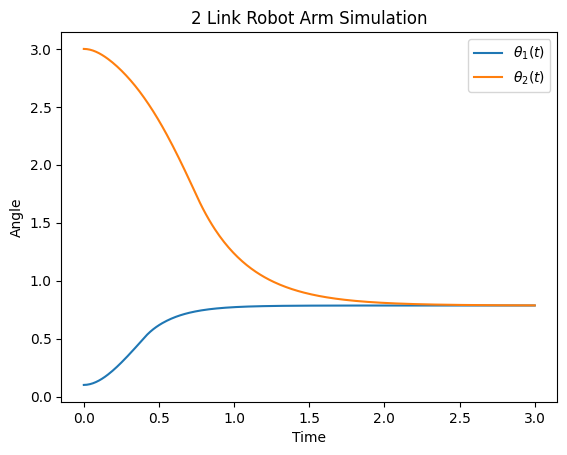

In [2]:
class RobotArmControl:
    def __init__(self, lambda_value=np.array([5, 5]) , K=np.array([15, 10]), x_set=np.array([np.pi/4, np.pi/4]) ):
        self.lambda_value = lambda_value
        self.K = K
        self.x_set = x_set
        
        self.e1_values = []
        self.e2_values = []
        self.de1_values = []
        self.de2_values = []

    def sliding_mode_control_law(self, th1, th2, dth1, dth2, ddth1_1, ddth1_2):
        e = np.array([th1, th2]) - self.x_set
        de = np.array([dth1, dth2])
        s = de + self.lambda_value * e
        u = -np.array([ddth1_1, ddth1_2]) - self.lambda_value * de - self.K * np.sign(s)

        self.e1_values.append(e[0])
        self.e2_values.append(e[1])
        self.de1_values.append(de[0])
        self.de2_values.append(de[1])
        return u
    
    def odes(self, t, x):
        m1, m2, l1, l2, g = .8, .4, 1, .5, 9.81
        th1, th2, dth1, dth2 = x 
        
        # Calculate -f for T1 = T2 = 0
        T1 = T2 = 0
        A = -g * (2 * m1 + m2) * np.sin(th1) - m2 * g * np.sin(th1 - 2 * th2) - 2 * np.sin(th1 - th2) * m2 * (dth2**2 * l2 + dth1**2 * l1 * np.cos(th1 - th2)) + T1
        B = l1 * (2 * m1 + m2 - m2 * np.cos(2 * th1 - 2 * th2))
        ddth1_1 = A / B

        C = 2 * np.sin(th1 - th2) * (dth1**2 * l1 * (m1 + m2) + g * (m1 + m2) * np.cos(th1) + dth2**2 * l2 * m2 * np.cos(th1 - th2)) + T2
        D = l2 * (2 * m1 + m2 - m2 * np.cos(2 * th1 - 2 * th2))
        ddth2_1 = C / D

        # Calculate control
        u = self.sliding_mode_control_law(th1, th2, dth1, dth2, ddth1_1, ddth2_1)
        T1, T2 = u

        # Calculate dynamics with torque input
        A = -g * (2 * m1 + m2) * np.sin(th1) - m2 * g * np.sin(th1 - 2 * th2) - 2 * np.sin(th1 - th2) * m2 * (dth2**2 * l2 + dth1**2 * l1 * np.cos(th1 - th2)) + T1
        B = l1 * (2 * m1 + m2 - m2 * np.cos(2 * th1 - 2 * th2))
        ddth1 = A / B

        C = 2 * np.sin(th1 - th2) * (dth1**2 * l1 * (m1 + m2) + g * (m1 + m2) * np.cos(th1) + dth2**2 * l2 * m2 * np.cos(th1 - th2)) + T2
        D = l2 * (2 * m1 + m2 - m2 * np.cos(2 * th1 - 2 * th2))
        ddth2 = C / D

        return [dth1, dth2, ddth1, ddth2]
    
# Set the control conditions
control = RobotArmControl(lambda_value=np.array([5, 3]), K=np.array([15, 8]), x_set=np.array([np.pi/4, np.pi/4]))

# Define the ODE function using the method from the class
def odes(t, x):
    return control.odes(t, x)

def event(t, y):
    print(f"Time: {t:.2f}", end="\r")  
    return 0  

event.terminal = False  
event.direction = 0     

t_span = [0, 3]
t_eval_points = np.linspace(t_span[0], t_span[1], 300)

x0 = [.1, 3, 0, 0]  
sol = solve_ivp(odes, t_span, x0, method='RK45', t_eval=t_eval_points, events=event)

plt.plot(sol.t, sol.y[0], label=r'$\theta_1(t)$')
plt.plot(sol.t, sol.y[1], label=r'$\theta_2(t)$')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Angle')
plt.title('2 Link Robot Arm Simulation')
plt.show()

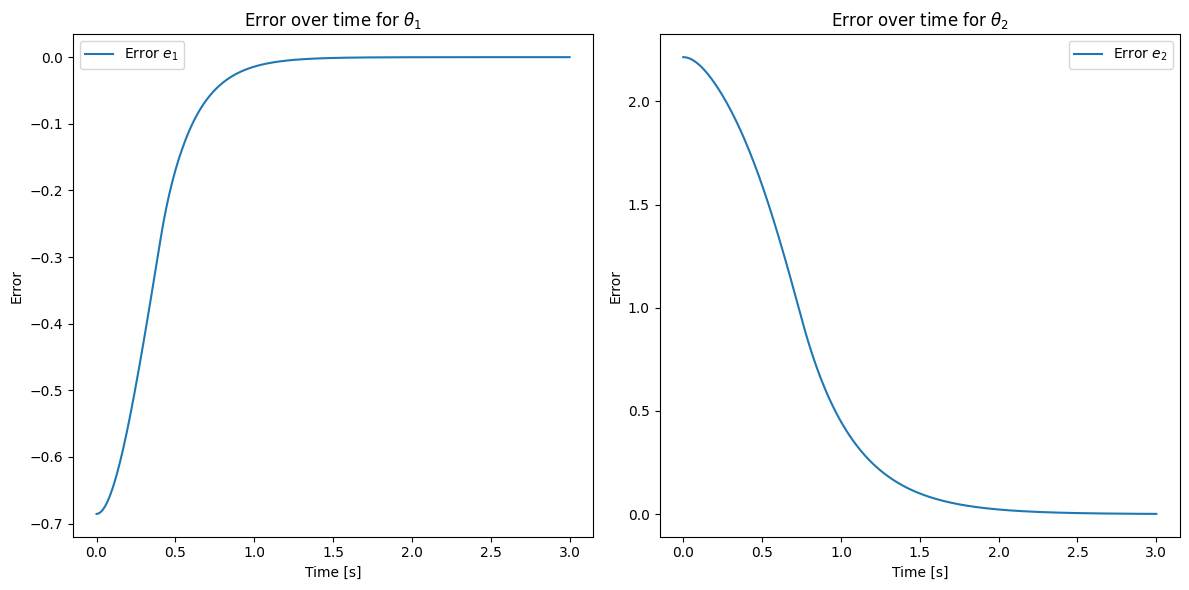

In [3]:
theta1_set, theta2_set = np.pi/4, np.pi/4

e1 = sol.y[0] - theta1_set
e2 = sol.y[1] - theta2_set

de1_dt = sol.y[2]  
de2_dt = sol.y[3]  

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(sol.t, e1, label=r'Error $e_1$')
plt.title('Error over time for $\\theta_1$')
plt.xlabel('Time [s]')
plt.ylabel('Error')
plt.legend()

# Plot error for theta2 over time
plt.subplot(1, 2, 2)
plt.plot(sol.t, e2, label=r'Error $e_2$')
plt.title('Error over time for $\\theta_2$')
plt.xlabel('Time [s]')
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
plt.show()

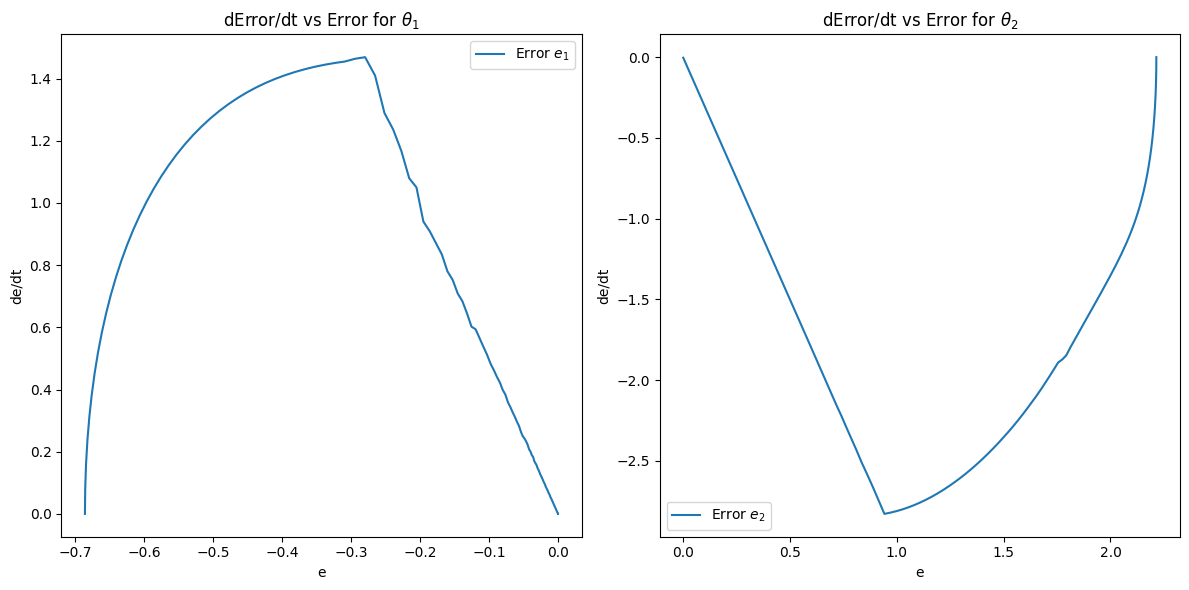

In [4]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(e1, de1_dt, label=r'Error $e_1$')
plt.title('dError/dt vs Error for $\\theta_1$')
plt.xlabel('e')
plt.ylabel('de/dt')
plt.legend()

# Plot error for theta2 over time
plt.subplot(1, 2, 2)
plt.plot(e2, de2_dt, label=r'Error $e_2$')
plt.title('dError/dt vs Error for $\\theta_2$')
plt.xlabel('e')
plt.ylabel('de/dt')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
# Generate GIF of robot arm motion

import imageio
def get_arm_positions(th1, th2, l1=1, l2=.5):
    x1 = l1 * np.sin(th1)
    y1 = l1 * np.cos(th1)
    x2 = x1 + l2 * np.sin(th2)
    y2 = y1 + l2 * np.cos(th2)
    
    return (0, 0), (x1, y1), (x2, y2)


filenames = []
for i in range(len(sol.t)):
    th1, th2 = sol.y[0, i], sol.y[1, i]
    positions = get_arm_positions(th1, th2)
    
    plt.figure()
    plt.plot([0, positions[1][0]], [0, positions[1][1]], 'r-') 
    plt.plot([positions[1][0], positions[2][0]], [positions[1][1], positions[2][1]], 'b-') 
    plt.scatter(*zip(*positions), s=100) # Joints
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.axis('off') 
    
    # Save the frame
    filename = f'pics/frame_{i}.png'
    plt.savefig(filename)
    plt.close()
    filenames.append(filename)

# Create a GIF
with imageio.get_writer('robot_arm.gif', mode='I', duration=10/1000) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Output the path to the GIF
gif_path = 'robot_arm.gif'
gif_path

/tmp/ipykernel_12430/2928437382.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


'robot_arm.gif'